<a href="https://colab.research.google.com/github/romulobrito/Model-LSTM-FC-Mass-Spring-Genetic-Aalgorithm/blob/main/C%C3%B3pia_de_massa_mola_lstm_correlacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction:

The purpose of this study is to model the behavior of a damped mass-spring system using the Euler method for simulation. In this implementation, positions, velocities, and kinetic and potential energies are calculated over time. In a subsequent step, a recurrent neural network (LSTM) is introduced. The LSTM is fed with the time series information of the system's position and velocities over time and is trained to predict kinetic and potential energies in future steps. The objective is to determine if the network is capable of making predictions of the kinetic and potential energies of the system based on inputs correlated to these quantities.To begin with, the model's hyperparameters were manually adjusted to ensure the most efficient performance. An iterative trial-and-error method was employed for this purpose. Various values were assigned to the hyperparameters, and the model was trained and evaluated to determine how these changes affected its performance. Once the hyperparameters were manually adjusted and the model was developed to operate within the limitations of the manual approach, a genetic algorithm was used to automate the optimization of the hyperparameters for even better performance.

The differential equation describing the motion of the mass is the equation of damped harmonic motion:

$$
m \frac{{d^2x}}{{dt^2}} + b \frac{{dx}}{{dt}} + kx = 0
$$

where:
- $ m $ is the mass of the particle,
- $ b $ is the damping coefficient,
- $ k $ is the spring constant,
- $ x(t) $ is the position of the mass relative to equilibrium,
- $ v(t) $ is the velocity of the mass, and
- $ \frac{{d^2x}}{{dt^2}} $ is the acceleration of the mass.

The iterative updates for the position and velocity of the mass over time are given by the equations:

$$
\begin{align*}
x_{t+1} &= x_t + v_t \cdot \Delta t \\
v_{t+1} &= v_t + a_t \cdot \Delta t \\
\end{align*}
$$

Where:
- $ x_t $ and $ v_t $ are, respectively, the position and velocity of the mass at time $ t $,
- $ a_t $ is the acceleration of the mass at time $ t $, and
- $ \Delta t $ is the time interval between updates.


##### Importing Libraries


In [ ]:
!pip install -q -r requirements.txt

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

##### Numerical Simulation:


In [2]:

def simulate_spring_mass_damped(
    initial_position,
    initial_velocity,
    num_steps,
    dt,
    k=1.0,
    m=2.0,
    b=0.1,
):
    positions = [initial_position]
    velocities = [initial_velocity]
    energies_potential = [0.5 * k * (initial_position**2)]
    energies_kinetic = [0.5 * m * (initial_velocity**2)]

    for _ in range(num_steps):
        position = positions[-1]
        velocity = velocities[-1]
        acceleration = -k / m * position - b / m * velocity
        position += velocity * dt
        velocity += acceleration * dt
        energy_potential = 0.5 * k * (position**2)
        energy_kinetic = 0.5 * m * (velocity**2)
        positions.append(position)
        velocities.append(velocity)
        energies_potential.append(energy_potential)
        energies_kinetic.append(energy_kinetic)


    return (
        np.array(positions),
        np.array(velocities),
        np.array(energies_potential),
        np.array(energies_kinetic),
    )

# Input simulação
initial_position = 2.0
initial_velocity = 0.0
num_steps = 2000
dt = 0.05
k = 1.0
m = 2.0
b = 0.1


positions, velocities, energies_potential, energies_kinetic = (
    simulate_spring_mass_damped(initial_position, initial_velocity, num_steps, dt, k, m, b)
)

### LSTM+FC Architecture


The architecture of the network consists of a batch normalization layer, an LSTM layer, and a fully connected linear layer. While the LSTM layer captures the temporal dependency of the data, the normalization layer is responsible for normalizing the input data. In turn, the outputs from the LSTM are mapped to the desired predictions by the fully connected layer.

As previously mentioned, the inputs for training the LSTM consist of sequences of data representing the positions and velocities of the damped mass-spring system over time. For each input sequence, there are pairs of position and velocity values occurring at different time steps. These sequences are encapsulated in PyTorch tensors, where the batch dimension is adjusted as (batch_size, seq_length, input_size), with "batch_size" being the batch size, "seq_length" the sequence length, and "input_size" the number of features at each time step. Thus, each input to the LSTM will have num_steps data points, corresponding to the number of time steps in the simulation, where the sequence length is determined by the number of time steps specified in the mass system simulation.

The data is split into training, validation, and test sets by proportionate splitting. The first part of the data is used for training, the second part is reserved for validation, and the third part is reserved for testing. This division ensures that the model is trained on a different dataset than those used for validation and testing, allowing for evaluation of how the model performs on new data.

The parameters of the LSTM are adjusted by the training inputs while the validation inputs monitor the model's performance during training. The test inputs are used to evaluate the final performance of the model on unseen data.

To begin with, the model's hyperparameters were manually adjusted to ensure the most efficient performance. An iterative trial-and-error method was employed for this purpose. Various values were assigned to the hyperparameters, and the model was trained and evaluated to determine how these changes affected its performance.

The learning rate, the size of the LSTM hidden layer, the number of LSTM layers, and other parameters related to the architecture and optimization of the neural network may be included in the manually adjusted hyperparameters.

This manual process was crucial for understanding how each hyperparameter affected the model's performance and discovering the values that yielded the best results. Once the hyperparameters were manually adjusted and the model was developed to operate within the limitations of the manual approach, a genetic algorithm was used to automate the optimization of the hyperparameters for even better performance.

##### Model (LSTM+FC) with Manual Hyperparameter Tuning





In [3]:
# Input LSTM
input_size = 2
hidden_size = 64
num_layers = 3
output_size = 2
learning_rate = 0.001
num_epochs = 1000


inputs = np.column_stack((positions[:-1], velocities[:-1]))
targets = np.column_stack((energies_potential[1:], energies_kinetic[1:]))

inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(1)
targets = torch.tensor(targets, dtype=torch.float32)

train_size = int(0.6 * num_steps)
val_size = int(0.2 * num_steps)
test_size = num_steps - train_size - val_size

train_inputs = inputs[:train_size]
val_inputs = inputs[train_size : train_size + val_size]
test_inputs = inputs[train_size + val_size :]

train_targets = targets[:train_size]
val_targets = targets[train_size : train_size + val_size]
test_targets = targets[train_size + val_size :]


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.norm = nn.BatchNorm1d(input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        for name, param in self.lstm.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)

        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):

        x = self.norm(x.permute(0, 2, 1)).permute(0, 2, 1)

        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

##### Model

Epoch [10/1000], Loss: 0.473168, Val Loss: 0.045863
Epoch [20/1000], Loss: 0.379481, Val Loss: 0.022233
Epoch [30/1000], Loss: 0.278397, Val Loss: 0.026759
Epoch [40/1000], Loss: 0.207591, Val Loss: 0.123971
Epoch [50/1000], Loss: 0.212991, Val Loss: 0.190677
Epoch [60/1000], Loss: 0.204635, Val Loss: 0.120441
Epoch [70/1000], Loss: 0.204280, Val Loss: 0.113109
Epoch [80/1000], Loss: 0.201850, Val Loss: 0.133094
Epoch [90/1000], Loss: 0.199484, Val Loss: 0.131237
Epoch [100/1000], Loss: 0.195071, Val Loss: 0.120984
Epoch [110/1000], Loss: 0.186938, Val Loss: 0.119655
Epoch [120/1000], Loss: 0.171716, Val Loss: 0.115660
Epoch [130/1000], Loss: 0.145589, Val Loss: 0.105871
Epoch [140/1000], Loss: 0.105873, Val Loss: 0.091927
Epoch [150/1000], Loss: 0.057575, Val Loss: 0.075441
Epoch [160/1000], Loss: 0.035285, Val Loss: 0.071372
Epoch [170/1000], Loss: 0.029858, Val Loss: 0.053483
Epoch [180/1000], Loss: 0.021639, Val Loss: 0.045771
Epoch [190/1000], Loss: 0.016622, Val Loss: 0.035081
Ep

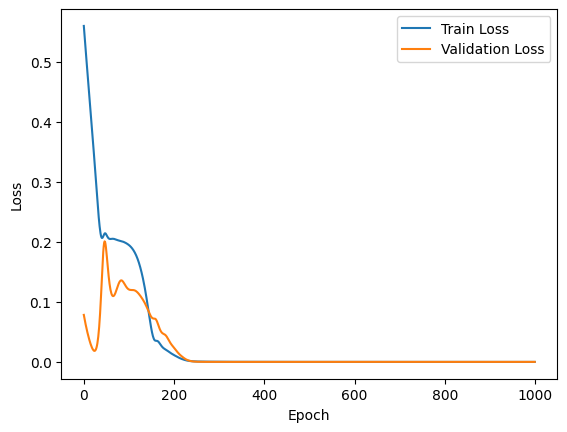

In [ ]:
model = LSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_inputs)
    loss = criterion(outputs, train_targets)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_targets)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}"
        )

model.eval()
with torch.no_grad():
    test_outputs = model(test_inputs)
    test_loss = criterion(test_outputs, test_targets)
    print(f"Test Loss: {test_loss.item():.4f}")

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

##### Test Set Prediction Plot


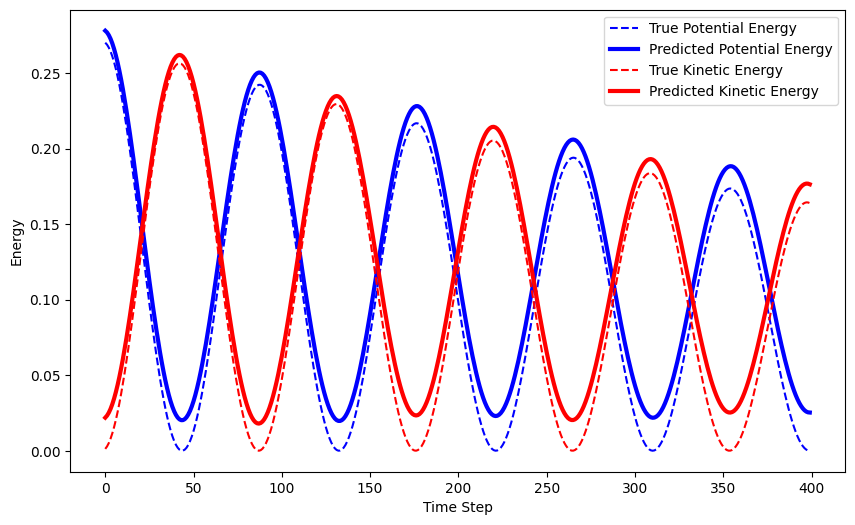

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_targets[:, 0], "b--", label="True Potential Energy")
plt.plot(test_outputs[:, 0], "-b", label="Predicted Potential Energy", lw=3)
plt.plot(test_targets[:, 1], "r--", label="True Kinetic Energy")
plt.plot(test_outputs[:, 1], "-r", label="Predicted Kinetic Energy", lw=3)
plt.xlabel("Time Step")
plt.ylabel("Energy")
plt.legend()
plt.show()

### Hyperparameter Optimization using GA (PyGAD)




The objective of the following code is to optimize the model's hyperparameters for predicting the kinetic and potential energies of a previously damped mass-spring system. Several actions were taken to achieve this goal.

Firstly, the fitness function evaluates the model's performance based on the provided hyperparameters. In this case, the fitness function takes the hyperparameters as input, constructs and trains the LSTM model with these hyperparameters, and then calculates a score based on the model's performance. The score is defined as inversely proportional to the model's error, where a lower error results in a higher score.
$$
\text{score} = \frac{1}{\text{val_loss} + \epsilon}
$$

where
- $\text{val_loss}$ is the model's validation loss.
- $\epsilon$ is a small value added to avoid division by zero.

The genetic algorithm was implemented with the Pygad library to optimize the hyperparameters of the LSTM model. This algorithm creates an initial population of candidate solutions, uses the fitness function to evaluate the performance of each solution, evolves the population over multiple generations by selecting the fittest parents and applying mutation and crossover operators to create a new population.

The genetic algorithm seeks to find the combination of hyperparameters that maximizes the LSTM model's performance in predicting potential and kinetic energies for damped mass-spring systems. For each step (set of generations), the fitness graph is plotted to track the convergence of the algorithm. After the genetic algorithm converges, the optimal combination of hyperparameters is chosen, and for this combination of hyperparameters, energy predictions are made for the test set.

It is important to note that only 200 epochs were considered to optimize the model's hyperparameters using the genetic algorithm. In most cases, this technique produced equivalent or better predictions (observe "Test Loss" for manual and optimized hyperparameter choices) than predictions made with 1000 epochs where hyperparameter choices were made manually through trial and error. This result emphasizes the effectiveness of the genetic algorithm in locating hyperparameter combinations in a relatively small search space, providing computational time savings by reducing the number of epochs. At the same time, using a lower number of epochs, the quality of the solution found in "Test Loss" was superior or similar in most cases.


Generation 1/30


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


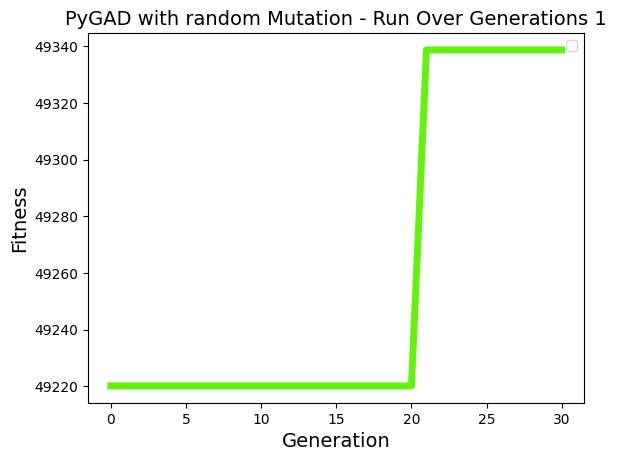

Generation 2/30
Generation 3/30
Generation 4/30
Generation 5/30
Generation 6/30


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


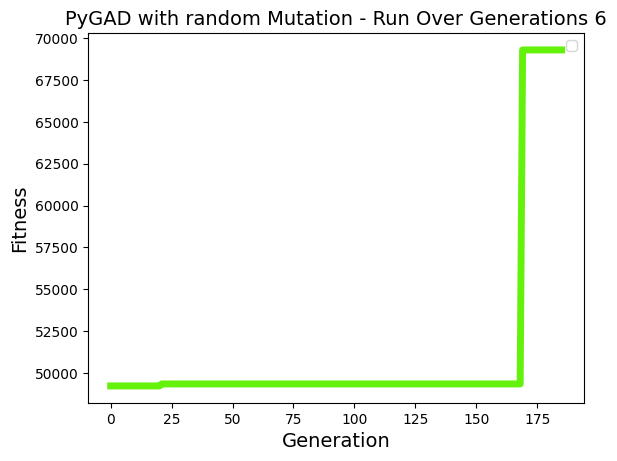

Generation 7/30


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


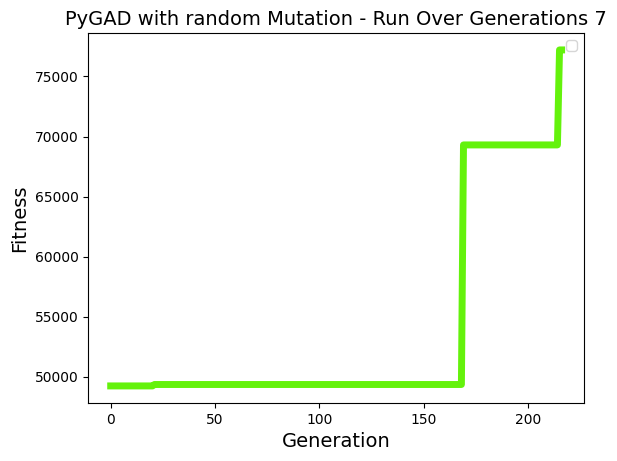

Generation 8/30
Generation 9/30
Generation 10/30


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


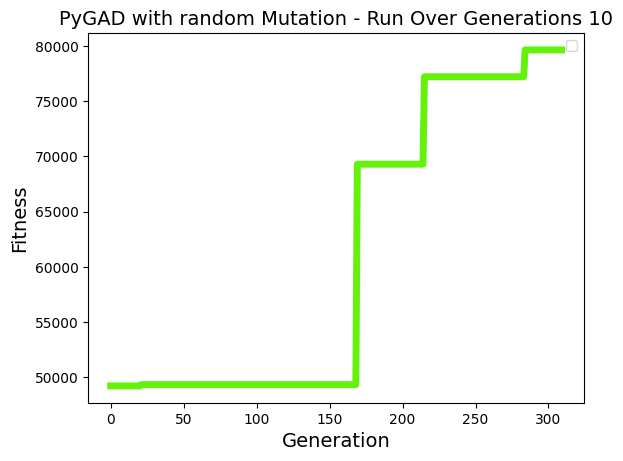

Generation 11/30
Generation 12/30
Generation 13/30


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


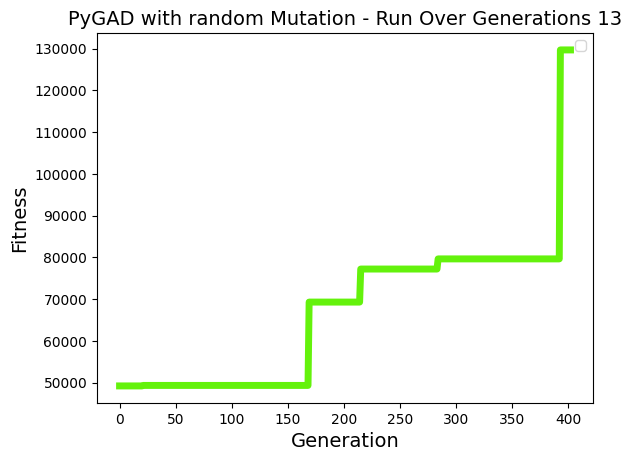

Generation 14/30
Generation 15/30
Generation 16/30
Generation 17/30
Generation 18/30
Generation 19/30


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


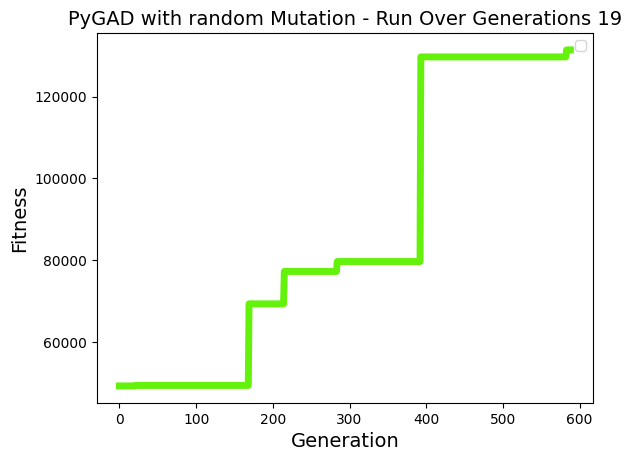

Generation 20/30
Generation 21/30
Generation 22/30
Generation 23/30
Generation 24/30
Generation 25/30
Generation 26/30
Generation 27/30
Generation 28/30
Generation 29/30
Generation 30/30


In [9]:
import pygad
num_epochs = 200
def fitness_func(ga_instance, solution, solution_idx):
    global train_inputs, train_targets, val_inputs, val_targets, input_size, output_size, num_layers
    hidden_size = int(solution[0])
    learning_rate = max(0.00001, solution[1])
    num_layers = max(1,int(solution[2]))

    # print("Fit Hidden Size:", hidden_size)
    # print("Fit Learning Rate:", learning_rate)
    # print("Fit Num Layers:", num_layers)

    model = LSTM(input_size, hidden_size, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_inputs)
        loss = criterion(outputs, train_targets)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_targets)

    score = 1.0 / (val_loss.item() + 1e-7)
    # print("Score", score)
    # print("Val error",val_loss.item() )
    # print("===============================================")
    return score


fitness_function = fitness_func

num_generations = 30
num_parents_mating = 2
sol_per_pop = 10
num_genes = 3  # Hidden size, Learning rate, Num layers

init_range_low = [16, 0.001, 2]
init_range_high = [64, 0.02, 6]
parent_selection_type = "tournament"  # rank
keep_parents = 1

crossover_type = "uniform" # "two_point", "uniform", "segment"


# mutation_type = "adaptive"
# mutation_probability =  [1, 0.1] #0.01 #
# mutation_percent_genes = np.array([15, 10]) #10 #

mutation_type = "random" #"adaptive"
mutation_probability =   0.01 #
mutation_percent_genes = 90 #

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       mutation_probability=mutation_probability)

previous = -1
for generation in range(num_generations):
    print(f"Generation {generation + 1}/{num_generations}")
    ga_instance.run()
    current = ga_instance.best_solution()[1]
    if current != previous:
        ga_instance.plot_fitness(title=f"PyGAD with {mutation_type} Mutation - Run Over Generations {generation + 1}", linewidth=5)
    previous = current

solution, solution_fitness, solution_idx = ga_instance.best_solution()

##### Selection of the Best Hyperparameters





In [10]:
hidden_size = int(solution[0])
learning_rate = solution[1]
hydden_layers = int(solution[2])

print("Optimized Hyperparameters:")
print("Hidden Size:", hidden_size)
print("Learning Rate:", learning_rate)
print("Number of Layers:", hydden_layers)

Optimized Hyperparameters:
Hidden Size: 51
Learning Rate: 0.019808051378475668
Number of Layers: 4


#### Training and Prediction with Optimized Hyperparameters




Epoch [10/1000], Loss: 0.217292, Val Loss: 0.091515
Epoch [20/1000], Loss: 0.204952, Val Loss: 0.116205
Epoch [30/1000], Loss: 0.111763, Val Loss: 0.138596
Epoch [40/1000], Loss: 0.073093, Val Loss: 0.107427
Epoch [50/1000], Loss: 0.053255, Val Loss: 0.101336
Epoch [60/1000], Loss: 0.033187, Val Loss: 0.036938
Epoch [70/1000], Loss: 0.022557, Val Loss: 0.034553
Epoch [80/1000], Loss: 0.008115, Val Loss: 0.004827
Epoch [90/1000], Loss: 0.004087, Val Loss: 0.001885
Epoch [100/1000], Loss: 0.001432, Val Loss: 0.001792
Epoch [110/1000], Loss: 0.000792, Val Loss: 0.000969
Epoch [120/1000], Loss: 0.000340, Val Loss: 0.000921
Epoch [130/1000], Loss: 0.000256, Val Loss: 0.000970
Epoch [140/1000], Loss: 0.000195, Val Loss: 0.001131
Epoch [150/1000], Loss: 0.000160, Val Loss: 0.000942
Epoch [160/1000], Loss: 0.000140, Val Loss: 0.000895
Epoch [170/1000], Loss: 0.000123, Val Loss: 0.000843
Epoch [180/1000], Loss: 0.000110, Val Loss: 0.000766
Epoch [190/1000], Loss: 0.000099, Val Loss: 0.000732
Ep

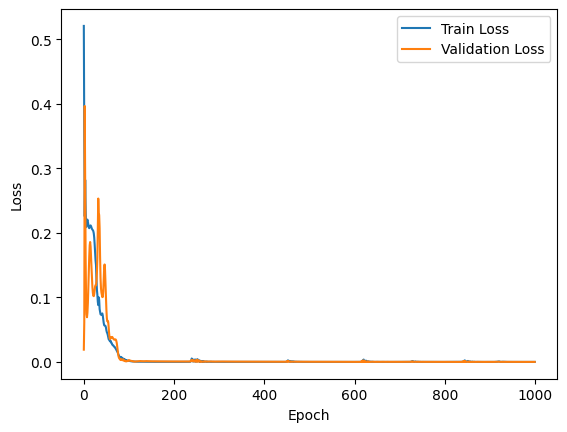

In [11]:
model = LSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_inputs)
    loss = criterion(outputs, train_targets)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_targets)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}"
        )

model.eval()
with torch.no_grad():
    test_outputs = model(test_inputs)
    test_loss = criterion(test_outputs, test_targets)
    print(f"Test Loss: {test_loss.item():.4f}")

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


#### Test Set Model Prediction Plot





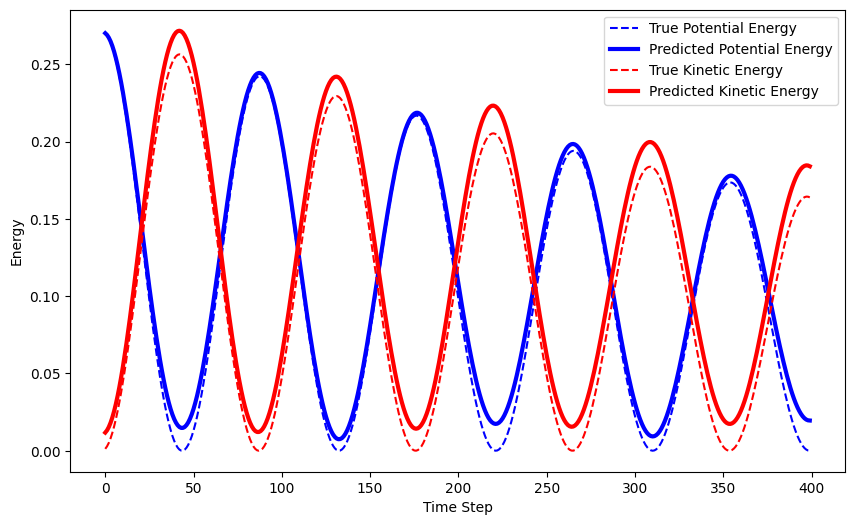

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(test_targets[:, 0], "b--", label="True Potential Energy")
plt.plot(test_outputs[:, 0], "-b", label="Predicted Potential Energy", lw=3)
plt.plot(test_targets[:, 1], "r--", label="True Kinetic Energy")
plt.plot(test_outputs[:, 1], "-r", label="Predicted Kinetic Energy", lw=3)
plt.xlabel("Time Step")
plt.ylabel("Energy")
plt.legend()
plt.show()